In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.65
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:


import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K


In [3]:

"""
基本設定
"""
n=210527 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #288個一組 (24小時一組)
currencynum=5
currency = ["BTC","DASH","ETH","LTC","XMR"]
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
#month = [0,10,20,30,40,50]
month2 = [397,425,456,486,517,547,578,609,639,670,700,731] #2017 365天
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
M=0

# 控制要不要存檔，1 : Yes, 0 : No
save = 1
epochs = 200
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
btc = 423.51
DASH = 0.00778 * btc
ETH = 0.0021652 * btc
LTC = 0.00805792 * btc
XMR = 0.00105001 * btc



In [4]:

"""
 V
"""
"""
diff
"""
df = pd.read_csv('btc_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btc5months = np.zeros(n)
for i in range(n):
    btc5months[i] = df[0][i]
df = pd.read_csv('DASH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
dash5months = np.zeros(n)
for i in range(n):
    dash5months[i] = df[0][i]
df = pd.read_csv('ETH_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
eth5months = np.zeros(n)
for i in range(n):
    eth5months[i] = df[0][i]
df = pd.read_csv('LTC_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ltc5months = np.zeros(n)
for i in range(n):
    ltc5months[i] = df[0][i]
df = pd.read_csv('XMR_data_return_diff.csv',header=None)  # 讀取訓練數據
print(df.shape)  
xmr5months = np.zeros(n)
for i in range(n):
    xmr5months[i] = df[0][i]    

(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)


In [5]:
"""
vol
"""    
df = pd.read_csv('bitcoin_data_return_volume.csv',header=None)  # 讀取訓練數據
print(df.shape)  
btcmonthsvol = np.zeros(n)
for i in range(n):
    btcmonthsvol[i] = df[0][i]
df = pd.read_csv('DASH_data_return_volume.csv',header=None)  # 讀取訓練數據
print(df.shape)  
DASHmonthsvol = np.zeros(n)
for i in range(n):
    DASHmonthsvol[i] = df[0][i]
df = pd.read_csv('ETH_data_return_volume.csv',header=None)  # 讀取訓練數據
print(df.shape)  
ETHmonthsvol = np.zeros(n)
for i in range(n):
    ETHmonthsvol[i] = df[0][i]
df = pd.read_csv('LTC_data_return_volume.csv',header=None)  # 讀取訓練數據
print(df.shape)  
LTCmonthsvol = np.zeros(n)
for i in range(n):
    LTCmonthsvol[i] = df[0][i]
df = pd.read_csv('XMR_data_return_volume.csv',header=None)  # 讀取訓練數據
print(df.shape)  
XMRmonthsvol = np.zeros(n)
for i in range(n):
    XMRmonthsvol[i] = df[0][i]
print('finish dataread')

(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
(210527, 1)
finish dataread


In [6]:
Train_data=np.zeros(((n-l+1,len(currency)*2,l)))
for p in range(n-l+1):
    Train_data[p,0,:]=btc5months[p:p+l]
    Train_data[p,1,:]=dash5months[p:p+l]
    Train_data[p,2,:]=eth5months[p:p+l]
    Train_data[p,3,:]=ltc5months[p:p+l]
    Train_data[p,4,:]=xmr5months[p:p+l]
    Train_data[p,5,:]=btcmonthsvol[p:p+l]
    Train_data[p,6,:]=DASHmonthsvol[p:p+l]
    Train_data[p,7,:]=ETHmonthsvol[p:p+l]
    Train_data[p,8,:]=LTCmonthsvol[p:p+l]
    Train_data[p,9,:]=XMRmonthsvol[p:p+l]    
    


In [7]:

"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)


"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((3))
        d = {0:tmp[0],1:tmp[1],2:tmp[2]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small','same']
HVqtype = ['big','small','same']


"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((5,1))
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])/(btc + np.sum(btc5months[:n]))
    outcome[1]=(data2_sum[1])/(DASH + np.sum(dash5months[:n]))
    outcome[2]=(data2_sum[2])/(ETH + np.sum(eth5months[:n]))
    outcome[3]=(data2_sum[3])/(LTC + np.sum(ltc5months[:n]))
    outcome[4]=(data2_sum[4])/(XMR + np.sum(xmr5months[:n]))

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(3):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] > outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        else:
             for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] == outcome[str_to_currency(all_cur_pair_P[j][1])] == 0):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)           
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((5,1))
    #data_std=np.std(data,axis=1)
    data2_std=np.std(data2,axis=1)    
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(3):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] > outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        else:
             for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] == outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)           
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)


In [8]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


In [9]:

"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(m1*288,m3*288-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)*288-72)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1)*288)*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    
    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=11.1 GiB, count=1883, average=6182 KiB
[Training model......]
Train on 1550880 samples, validate on 514080 samples
Epoch 1/200
1550880/1550880 [==============================] - 970s 625us/step - loss: 3.2269 - acc: 0.6090 - val_loss: 0.5647 - val_acc: 0.7137
Epoch 2/200
1550880/1550880 [==============================] - 152s 98us/step - loss: 0.5749 - acc: 0.6739 - val_loss: 0.4645 - val_acc: 0.7502
Epoch 3/200
1550880/1550880 [==============================] - 152s 98us/step - loss: 0.4767 - acc: 0.7149 - val_loss: 0.4124 - val_acc: 0.7783
Epoch 4/200
1550880/1550880 [==============================] - 151s 98us/step - loss: 0.4282 - acc: 0.7413 - val_loss: 0.3737 - val_acc: 0.7943
Epoch 5/200
1550880/1550880 [==============================] - 151s 98us/step - loss: 0.3909 - acc: 0.7589 - val_loss: 0.3503 - val_acc: 0.8002
Epoch 6/200
1550880/1550880 [=================

Epoch 56/200
1550880/1550880 [==============================] - 151s 97us/step - loss: 0.2732 - acc: 0.8178 - val_loss: 0.3451 - val_acc: 0.8125
Epoch 57/200
1550880/1550880 [==============================] - 151s 97us/step - loss: 0.2729 - acc: 0.8179 - val_loss: 0.3449 - val_acc: 0.8125
Epoch 58/200
1550880/1550880 [==============================] - 151s 97us/step - loss: 0.2727 - acc: 0.8179 - val_loss: 0.3458 - val_acc: 0.8125
Epoch 59/200
1550880/1550880 [==============================] - 151s 97us/step - loss: 0.2720 - acc: 0.8181 - val_loss: 0.3448 - val_acc: 0.8124
Epoch 60/200
1550880/1550880 [==============================] - 151s 97us/step - loss: 0.2719 - acc: 0.8182 - val_loss: 0.3453 - val_acc: 0.8124
Epoch 61/200
1550880/1550880 [==============================] - 150s 97us/step - loss: 0.2715 - acc: 0.8182 - val_loss: 0.3452 - val_acc: 0.8124
Epoch 62/200
1550880/1550880 [==============================] - 150s 97us/step - loss: 0.2714 - acc: 0.8182 - val_loss: 0.3448 - v

1550880/1550880 [==============================] - 150s 97us/step - loss: 0.2605 - acc: 0.8226 - val_loss: 0.3686 - val_acc: 0.8125
Epoch 113/200
1550880/1550880 [==============================] - 150s 97us/step - loss: 0.2606 - acc: 0.8227 - val_loss: 0.3661 - val_acc: 0.8125
Epoch 114/200
1550880/1550880 [==============================] - 150s 97us/step - loss: 0.2605 - acc: 0.8227 - val_loss: 0.3662 - val_acc: 0.8125
Epoch 115/200
1550880/1550880 [==============================] - 150s 96us/step - loss: 0.2601 - acc: 0.8228 - val_loss: 0.3689 - val_acc: 0.8126
Epoch 116/200
1550880/1550880 [==============================] - 150s 96us/step - loss: 0.2601 - acc: 0.8229 - val_loss: 0.3710 - val_acc: 0.8124
Epoch 117/200
1550880/1550880 [==============================] - 150s 96us/step - loss: 0.2599 - acc: 0.8230 - val_loss: 0.3726 - val_acc: 0.8125
Epoch 118/200
1550880/1550880 [==============================] - 150s 96us/step - loss: 0.2597 - acc: 0.8230 - val_loss: 0.3719 - val_acc:

1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2531 - acc: 0.8257 - val_loss: 0.4099 - val_acc: 0.8121
Epoch 169/200
1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2529 - acc: 0.8258 - val_loss: 0.4119 - val_acc: 0.8122
Epoch 170/200
1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2528 - acc: 0.8259 - val_loss: 0.4084 - val_acc: 0.8121
Epoch 171/200
1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2528 - acc: 0.8259 - val_loss: 0.4096 - val_acc: 0.8122
Epoch 172/200
1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2526 - acc: 0.8259 - val_loss: 0.4108 - val_acc: 0.8122
Epoch 173/200
1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2527 - acc: 0.8260 - val_loss: 0.4111 - val_acc: 0.8121
Epoch 174/200
1550880/1550880 [==============================] - 149s 96us/step - loss: 0.2528 - acc: 0.8259 - val_loss: 0.4120 - val_acc:

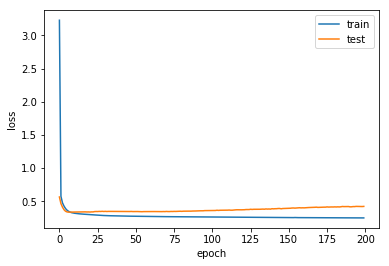

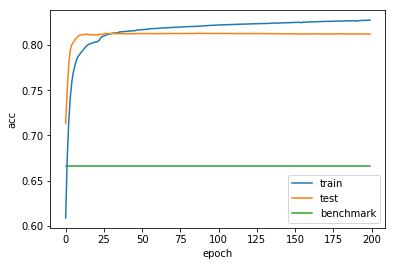

g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=16.7 GiB, count=929, average=18.4 MiB
[Training model......]
Train on 1533600 samples, validate on 531360 samples
Epoch 1/200
1533600/1533600 [==============================] - 1122s 732us/step - loss: 2.8294 - acc: 0.6229 - val_loss: 0.6116 - val_acc: 0.7306
Epoch 2/200
1533600/1533600 [==============================] - 152s 99us/step - loss: 0.6036 - acc: 0.6922 - val_loss: 0.4780 - val_acc: 0.7621
Epoch 3/200
1533600/1533600 [==============================] - 151s 99us/step - loss: 0.4577 - acc: 0.7342 - val_loss: 0.4244 - val_acc: 0.7761
Epoch 4/200
1533600/1533600 [==============================] - 151s 98us/step - loss: 0.4074 - acc: 0.7624 - val_loss: 0.3976 - val_acc: 0.7834
Epoch 5/200
1533600/1533600 [==============================] - 151s 98us/step - loss: 0.3762 - acc: 0.7766 - val_loss: 0.3842 - val_acc: 0.7869
Epoch 6/200
1533600/1533600 [=================

Epoch 56/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2743 - acc: 0.8158 - val_loss: 0.3446 - val_acc: 0.7954
Epoch 57/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2741 - acc: 0.8158 - val_loss: 0.3458 - val_acc: 0.7955
Epoch 58/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2736 - acc: 0.8161 - val_loss: 0.3442 - val_acc: 0.7954
Epoch 59/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2732 - acc: 0.8161 - val_loss: 0.3457 - val_acc: 0.7952
Epoch 60/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2730 - acc: 0.8163 - val_loss: 0.3457 - val_acc: 0.7950
Epoch 61/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2727 - acc: 0.8163 - val_loss: 0.3471 - val_acc: 0.7952
Epoch 62/200
1533600/1533600 [==============================] - 150s 98us/step - loss: 0.2725 - acc: 0.8165 - val_loss: 0.3453 - v

1533600/1533600 [==============================] - 149s 97us/step - loss: 0.2604 - acc: 0.8201 - val_loss: 0.3735 - val_acc: 0.7942
Epoch 113/200
1533600/1533600 [==============================] - 148s 97us/step - loss: 0.2602 - acc: 0.8205 - val_loss: 0.3744 - val_acc: 0.7943
Epoch 114/200
1533600/1533600 [==============================] - 149s 97us/step - loss: 0.2602 - acc: 0.8207 - val_loss: 0.3795 - val_acc: 0.7943
Epoch 115/200
1533600/1533600 [==============================] - 148s 97us/step - loss: 0.2599 - acc: 0.8211 - val_loss: 0.3844 - val_acc: 0.7945
Epoch 116/200
1533600/1533600 [==============================] - 148s 97us/step - loss: 0.2596 - acc: 0.8208 - val_loss: 0.3852 - val_acc: 0.7945
Epoch 117/200
1533600/1533600 [==============================] - 148s 97us/step - loss: 0.2594 - acc: 0.8207 - val_loss: 0.3772 - val_acc: 0.7943
Epoch 118/200
1533600/1533600 [==============================] - 148s 97us/step - loss: 0.2594 - acc: 0.8210 - val_loss: 0.3813 - val_acc:

1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2513 - acc: 0.8248 - val_loss: 0.4544 - val_acc: 0.7947
Epoch 169/200
1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2514 - acc: 0.8249 - val_loss: 0.4487 - val_acc: 0.7946
Epoch 170/200
1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2512 - acc: 0.8248 - val_loss: 0.4621 - val_acc: 0.7950
Epoch 171/200
1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2510 - acc: 0.8249 - val_loss: 0.4692 - val_acc: 0.7953
Epoch 172/200
1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2508 - acc: 0.8252 - val_loss: 0.4563 - val_acc: 0.7944
Epoch 173/200
1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2507 - acc: 0.8248 - val_loss: 0.4678 - val_acc: 0.7949
Epoch 174/200
1533600/1533600 [==============================] - 147s 96us/step - loss: 0.2506 - acc: 0.8250 - val_loss: 0.4696 - val_acc:

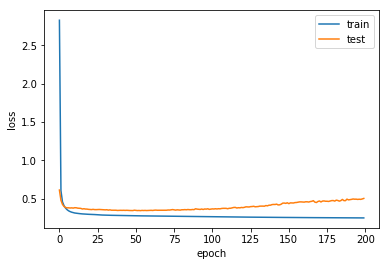

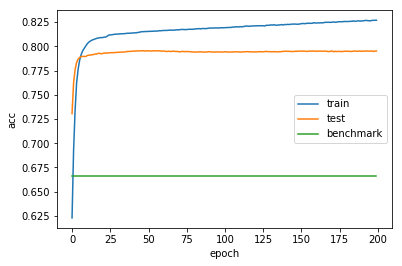

g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=16.7 GiB, count=930, average=18.4 MiB
[Training model......]
Train on 1585440 samples, validate on 514080 samples
Epoch 1/200
1585440/1585440 [==============================] - 1004s 633us/step - loss: 2.5428 - acc: 0.6154 - val_loss: 0.5477 - val_acc: 0.7445
Epoch 2/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.5327 - acc: 0.6973 - val_loss: 0.4584 - val_acc: 0.7538
Epoch 3/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.4568 - acc: 0.7387 - val_loss: 0.4216 - val_acc: 0.7626
Epoch 4/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.4174 - acc: 0.7685 - val_loss: 0.3950 - val_acc: 0.7725
Epoch 5/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.3885 - acc: 0.7814 - val_loss: 0.3693 - val_acc: 0.7776
Epoch 6/200
1585440/1585440 [=================

Epoch 56/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2846 - acc: 0.8058 - val_loss: 0.2982 - val_acc: 0.7948
Epoch 57/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2845 - acc: 0.8059 - val_loss: 0.2973 - val_acc: 0.7951
Epoch 58/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2843 - acc: 0.8060 - val_loss: 0.2975 - val_acc: 0.7952
Epoch 59/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2841 - acc: 0.8060 - val_loss: 0.2979 - val_acc: 0.7950
Epoch 60/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2839 - acc: 0.8059 - val_loss: 0.2971 - val_acc: 0.7954
Epoch 61/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2836 - acc: 0.8060 - val_loss: 0.2978 - val_acc: 0.7955
Epoch 62/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.2834 - acc: 0.8063 - val_loss: 0.2974 - v

1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2735 - acc: 0.8116 - val_loss: 0.2971 - val_acc: 0.8051
Epoch 113/200
1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2735 - acc: 0.8117 - val_loss: 0.2973 - val_acc: 0.8047
Epoch 114/200
1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2736 - acc: 0.8119 - val_loss: 0.2975 - val_acc: 0.8047
Epoch 115/200
1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2735 - acc: 0.8119 - val_loss: 0.2963 - val_acc: 0.8048
Epoch 116/200
1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2732 - acc: 0.8118 - val_loss: 0.2967 - val_acc: 0.8050
Epoch 117/200
1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2730 - acc: 0.8119 - val_loss: 0.2970 - val_acc: 0.8050
Epoch 118/200
1585440/1585440 [==============================] - 152s 96us/step - loss: 0.2728 - acc: 0.8120 - val_loss: 0.2994 - val_acc:

1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2661 - acc: 0.8167 - val_loss: 0.3018 - val_acc: 0.8050
Epoch 169/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2660 - acc: 0.8171 - val_loss: 0.3004 - val_acc: 0.8051
Epoch 170/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2660 - acc: 0.8170 - val_loss: 0.2997 - val_acc: 0.8048
Epoch 171/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2657 - acc: 0.8171 - val_loss: 0.2985 - val_acc: 0.8049
Epoch 172/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2657 - acc: 0.8174 - val_loss: 0.2995 - val_acc: 0.8049
Epoch 173/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2655 - acc: 0.8174 - val_loss: 0.2990 - val_acc: 0.8051
Epoch 174/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2656 - acc: 0.8174 - val_loss: 0.2990 - val_acc:

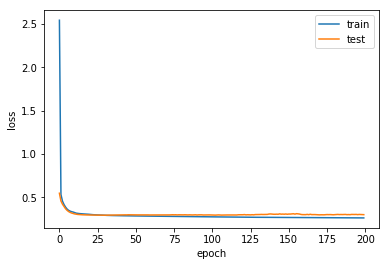

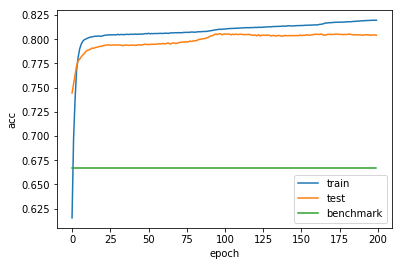

g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=16.8 GiB, count=931, average=18.5 MiB
[Training model......]
Train on 1568160 samples, validate on 531360 samples
Epoch 1/200
1568160/1568160 [==============================] - 1052s 671us/step - loss: 5.1250 - acc: 0.6388 - val_loss: 0.5493 - val_acc: 0.7554
Epoch 2/200
1568160/1568160 [==============================] - 154s 98us/step - loss: 0.8266 - acc: 0.6841 - val_loss: 0.3950 - val_acc: 0.7740
Epoch 3/200
1568160/1568160 [==============================] - 154s 98us/step - loss: 0.4686 - acc: 0.7272 - val_loss: 0.3659 - val_acc: 0.7889
Epoch 4/200
1568160/1568160 [==============================] - 153s 98us/step - loss: 0.4237 - acc: 0.7524 - val_loss: 0.3459 - val_acc: 0.7930
Epoch 5/200
1568160/1568160 [==============================] - 153s 98us/step - loss: 0.3975 - acc: 0.7679 - val_loss: 0.3278 - val_acc: 0.7956
Epoch 6/200
1568160/1568160 [=================

Epoch 56/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2836 - acc: 0.8066 - val_loss: 0.2830 - val_acc: 0.8004
Epoch 57/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2834 - acc: 0.8069 - val_loss: 0.2829 - val_acc: 0.8016
Epoch 58/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2832 - acc: 0.8069 - val_loss: 0.2833 - val_acc: 0.8003
Epoch 59/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2829 - acc: 0.8078 - val_loss: 0.2836 - val_acc: 0.8013
Epoch 60/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2825 - acc: 0.8085 - val_loss: 0.2838 - val_acc: 0.8012
Epoch 61/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2821 - acc: 0.8093 - val_loss: 0.2842 - val_acc: 0.8007
Epoch 62/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2817 - acc: 0.8096 - val_loss: 0.2842 - v

1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2687 - acc: 0.8175 - val_loss: 0.2885 - val_acc: 0.8034
Epoch 113/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2686 - acc: 0.8176 - val_loss: 0.2881 - val_acc: 0.8034
Epoch 114/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2681 - acc: 0.8179 - val_loss: 0.2885 - val_acc: 0.8032
Epoch 115/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2683 - acc: 0.8180 - val_loss: 0.2884 - val_acc: 0.8038
Epoch 116/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2681 - acc: 0.8178 - val_loss: 0.2888 - val_acc: 0.8034
Epoch 117/200
1568160/1568160 [==============================] - 151s 96us/step - loss: 0.2677 - acc: 0.8182 - val_loss: 0.2885 - val_acc: 0.8037
Epoch 118/200
1568160/1568160 [==============================] - 150s 96us/step - loss: 0.2677 - acc: 0.8180 - val_loss: 0.2881 - val_acc:

1568160/1568160 [==============================] - 150s 95us/step - loss: 0.2596 - acc: 0.8223 - val_loss: 0.2904 - val_acc: 0.8026
Epoch 169/200
1568160/1568160 [==============================] - 149s 95us/step - loss: 0.2595 - acc: 0.8223 - val_loss: 0.2905 - val_acc: 0.8027
Epoch 170/200
1568160/1568160 [==============================] - 149s 95us/step - loss: 0.2593 - acc: 0.8224 - val_loss: 0.2906 - val_acc: 0.8027
Epoch 171/200
1568160/1568160 [==============================] - 149s 95us/step - loss: 0.2591 - acc: 0.8223 - val_loss: 0.2902 - val_acc: 0.8025
Epoch 172/200
1568160/1568160 [==============================] - 149s 95us/step - loss: 0.2589 - acc: 0.8226 - val_loss: 0.2910 - val_acc: 0.8027
Epoch 173/200
1568160/1568160 [==============================] - 149s 95us/step - loss: 0.2588 - acc: 0.8225 - val_loss: 0.2908 - val_acc: 0.8028
Epoch 174/200
1568160/1568160 [==============================] - 149s 95us/step - loss: 0.2588 - acc: 0.8228 - val_loss: 0.2904 - val_acc:

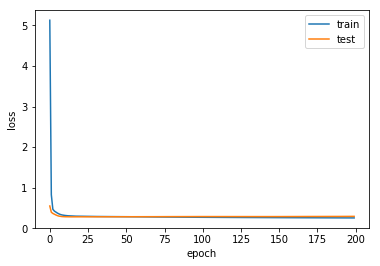

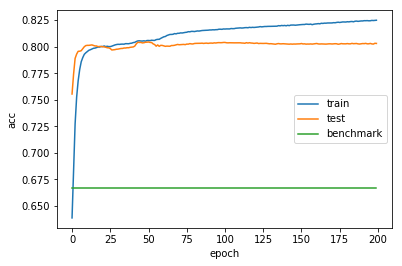

g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=11.2 GiB, count=930, average=12.4 MiB
[Training model......]
Train on 1585440 samples, validate on 531360 samples
Epoch 1/200
1585440/1585440 [==============================] - 836s 527us/step - loss: 3.0476 - acc: 0.5942 - val_loss: 0.5669 - val_acc: 0.7307
Epoch 2/200
1585440/1585440 [==============================] - 156s 98us/step - loss: 0.6049 - acc: 0.6829 - val_loss: 0.4491 - val_acc: 0.7737
Epoch 3/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.5002 - acc: 0.7307 - val_loss: 0.4018 - val_acc: 0.7812
Epoch 4/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.4405 - acc: 0.7551 - val_loss: 0.3801 - val_acc: 0.7824
Epoch 5/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.3982 - acc: 0.7692 - val_loss: 0.3625 - val_acc: 0.7837
Epoch 6/200
1585440/1585440 [==================

Epoch 56/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2781 - acc: 0.8057 - val_loss: 0.3451 - val_acc: 0.7952
Epoch 57/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2780 - acc: 0.8058 - val_loss: 0.3450 - val_acc: 0.7951
Epoch 58/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2778 - acc: 0.8059 - val_loss: 0.3475 - val_acc: 0.7947
Epoch 59/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2777 - acc: 0.8060 - val_loss: 0.3482 - val_acc: 0.7955
Epoch 60/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2777 - acc: 0.8059 - val_loss: 0.3455 - val_acc: 0.7955
Epoch 61/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2774 - acc: 0.8062 - val_loss: 0.3468 - val_acc: 0.7952
Epoch 62/200
1585440/1585440 [==============================] - 151s 95us/step - loss: 0.2772 - acc: 0.8062 - val_loss: 0.3507 - v

1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2721 - acc: 0.8116 - val_loss: 0.3927 - val_acc: 0.7945
Epoch 113/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2720 - acc: 0.8119 - val_loss: 0.3887 - val_acc: 0.7947
Epoch 114/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2719 - acc: 0.8119 - val_loss: 0.3858 - val_acc: 0.7949
Epoch 115/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2717 - acc: 0.8120 - val_loss: 0.3887 - val_acc: 0.7945
Epoch 116/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2717 - acc: 0.8120 - val_loss: 0.3820 - val_acc: 0.7947
Epoch 117/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2716 - acc: 0.8119 - val_loss: 0.3932 - val_acc: 0.7945
Epoch 118/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2714 - acc: 0.8121 - val_loss: 0.3863 - val_acc:

1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2649 - acc: 0.8162 - val_loss: 0.3784 - val_acc: 0.7949
Epoch 169/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2644 - acc: 0.8166 - val_loss: 0.3836 - val_acc: 0.7945
Epoch 170/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2644 - acc: 0.8167 - val_loss: 0.3739 - val_acc: 0.7946
Epoch 171/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2643 - acc: 0.8167 - val_loss: 0.3743 - val_acc: 0.7947
Epoch 172/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2640 - acc: 0.8168 - val_loss: 0.3727 - val_acc: 0.7949
Epoch 173/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2640 - acc: 0.8169 - val_loss: 0.3805 - val_acc: 0.7951
Epoch 174/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2640 - acc: 0.8169 - val_loss: 0.3757 - val_acc:

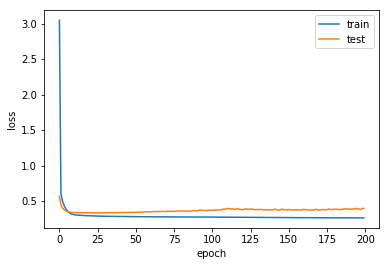

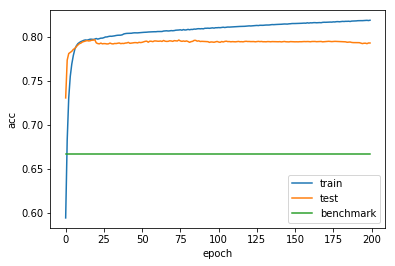

g_MLP
drop_out
compile model success
17
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=11.2 GiB, count=931, average=12.3 MiB
[Training model......]
Train on 1585440 samples, validate on 514080 samples
Epoch 1/200
1585440/1585440 [==============================] - 789s 498us/step - loss: 4.2918 - acc: 0.6349 - val_loss: 0.5670 - val_acc: 0.7617
Epoch 2/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.6501 - acc: 0.6914 - val_loss: 0.4219 - val_acc: 0.7751
Epoch 3/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.4639 - acc: 0.7137 - val_loss: 0.3786 - val_acc: 0.7995
Epoch 4/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.4231 - acc: 0.7520 - val_loss: 0.3442 - val_acc: 0.8122
Epoch 5/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.3912 - acc: 0.7685 - val_loss: 0.3257 - val_acc: 0.8161
Epoch 6/200
1585440/1585440 [==================

Epoch 56/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2810 - acc: 0.8012 - val_loss: 0.2919 - val_acc: 0.7932
Epoch 57/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2810 - acc: 0.8009 - val_loss: 0.2910 - val_acc: 0.7928
Epoch 58/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2809 - acc: 0.8011 - val_loss: 0.2912 - val_acc: 0.7928
Epoch 59/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2807 - acc: 0.8012 - val_loss: 0.2919 - val_acc: 0.7942
Epoch 60/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2806 - acc: 0.8015 - val_loss: 0.2903 - val_acc: 0.7943
Epoch 61/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2805 - acc: 0.8014 - val_loss: 0.2928 - val_acc: 0.7941
Epoch 62/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2804 - acc: 0.8017 - val_loss: 0.2922 - v

1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2758 - acc: 0.8061 - val_loss: 0.3097 - val_acc: 0.7865
Epoch 113/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2758 - acc: 0.8062 - val_loss: 0.3054 - val_acc: 0.7874
Epoch 114/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2757 - acc: 0.8063 - val_loss: 0.3080 - val_acc: 0.7893
Epoch 115/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2754 - acc: 0.8067 - val_loss: 0.3112 - val_acc: 0.7894
Epoch 116/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2754 - acc: 0.8068 - val_loss: 0.3120 - val_acc: 0.7884
Epoch 117/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2753 - acc: 0.8068 - val_loss: 0.3117 - val_acc: 0.7901
Epoch 118/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2755 - acc: 0.8067 - val_loss: 0.3109 - val_acc:

1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2699 - acc: 0.8115 - val_loss: 0.2971 - val_acc: 0.7836
Epoch 169/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2698 - acc: 0.8117 - val_loss: 0.2969 - val_acc: 0.7840
Epoch 170/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2700 - acc: 0.8117 - val_loss: 0.2953 - val_acc: 0.7852
Epoch 171/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2699 - acc: 0.8114 - val_loss: 0.2973 - val_acc: 0.7842
Epoch 172/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2698 - acc: 0.8120 - val_loss: 0.2966 - val_acc: 0.7832
Epoch 173/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2698 - acc: 0.8118 - val_loss: 0.2964 - val_acc: 0.7833
Epoch 174/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2694 - acc: 0.8121 - val_loss: 0.2966 - val_acc:

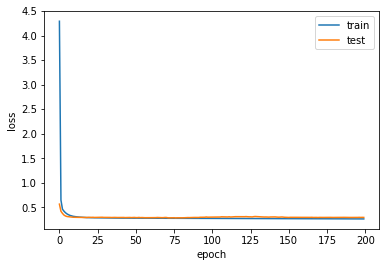

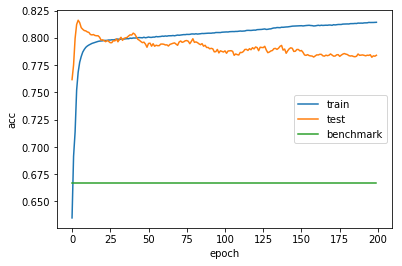

g_MLP
drop_out
compile model success
18
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=16.9 GiB, count=938, average=18.4 MiB
[Training model......]
Train on 1585440 samples, validate on 531360 samples
Epoch 1/200
1585440/1585440 [==============================] - 801s 505us/step - loss: 2.7057 - acc: 0.5852 - val_loss: 0.5125 - val_acc: 0.7529
Epoch 2/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.6123 - acc: 0.6517 - val_loss: 0.4326 - val_acc: 0.7624
Epoch 3/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.5006 - acc: 0.6949 - val_loss: 0.3866 - val_acc: 0.7849
Epoch 4/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.4355 - acc: 0.7236 - val_loss: 0.3475 - val_acc: 0.8002
Epoch 5/200
1585440/1585440 [==============================] - 155s 98us/step - loss: 0.3959 - acc: 0.7509 - val_loss: 0.3190 - val_acc: 0.8045
Epoch 6/200
1585440/1585440 [==================

Epoch 56/200
1585440/1585440 [==============================] - 150s 95us/step - loss: 0.2735 - acc: 0.8092 - val_loss: 0.2773 - val_acc: 0.8315
Epoch 57/200
1585440/1585440 [==============================] - 150s 95us/step - loss: 0.2734 - acc: 0.8092 - val_loss: 0.2805 - val_acc: 0.8313
Epoch 58/200
1585440/1585440 [==============================] - 150s 95us/step - loss: 0.2730 - acc: 0.8099 - val_loss: 0.2781 - val_acc: 0.8302
Epoch 59/200
1585440/1585440 [==============================] - 150s 95us/step - loss: 0.2729 - acc: 0.8094 - val_loss: 0.2799 - val_acc: 0.8311
Epoch 60/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2727 - acc: 0.8095 - val_loss: 0.2807 - val_acc: 0.8311
Epoch 61/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2727 - acc: 0.8095 - val_loss: 0.2786 - val_acc: 0.8310
Epoch 62/200
1585440/1585440 [==============================] - 150s 94us/step - loss: 0.2726 - acc: 0.8095 - val_loss: 0.2795 - v

1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2646 - acc: 0.8156 - val_loss: 0.2940 - val_acc: 0.8318
Epoch 113/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2648 - acc: 0.8157 - val_loss: 0.2955 - val_acc: 0.8320
Epoch 114/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2645 - acc: 0.8157 - val_loss: 0.2949 - val_acc: 0.8322
Epoch 115/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2645 - acc: 0.8158 - val_loss: 0.2939 - val_acc: 0.8319
Epoch 116/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2645 - acc: 0.8159 - val_loss: 0.2949 - val_acc: 0.8322
Epoch 117/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2642 - acc: 0.8159 - val_loss: 0.2945 - val_acc: 0.8323
Epoch 118/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2641 - acc: 0.8160 - val_loss: 0.2954 - val_acc:

1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2572 - acc: 0.8204 - val_loss: 0.3007 - val_acc: 0.8334
Epoch 169/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2570 - acc: 0.8206 - val_loss: 0.2985 - val_acc: 0.8333
Epoch 170/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2570 - acc: 0.8204 - val_loss: 0.3012 - val_acc: 0.8335
Epoch 171/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2569 - acc: 0.8205 - val_loss: 0.3012 - val_acc: 0.8335
Epoch 172/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2567 - acc: 0.8206 - val_loss: 0.2997 - val_acc: 0.8331
Epoch 173/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2565 - acc: 0.8210 - val_loss: 0.3014 - val_acc: 0.8337
Epoch 174/200
1585440/1585440 [==============================] - 149s 94us/step - loss: 0.2565 - acc: 0.8209 - val_loss: 0.3017 - val_acc:

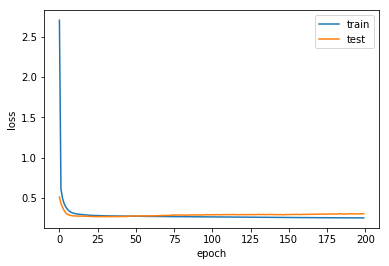

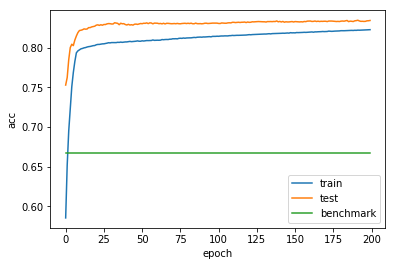

g_MLP
drop_out
compile model success
19
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=16.9 GiB, count=938, average=18.4 MiB
[Training model......]
Train on 1585440 samples, validate on 514080 samples
Epoch 1/200
1585440/1585440 [==============================] - 796s 502us/step - loss: 3.5483 - acc: 0.5825 - val_loss: 0.7066 - val_acc: 0.7057
Epoch 2/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.6197 - acc: 0.6509 - val_loss: 0.5515 - val_acc: 0.7199
Epoch 3/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.5106 - acc: 0.6940 - val_loss: 0.4862 - val_acc: 0.7516
Epoch 4/200
1585440/1585440 [==============================] - 154s 97us/step - loss: 0.4461 - acc: 0.7239 - val_loss: 0.4225 - val_acc: 0.7701
Epoch 5/200
1585440/1585440 [==============================] - 153s 97us/step - loss: 0.3974 - acc: 0.7427 - val_loss: 0.3831 - val_acc: 0.7784
Epoch 6/200
1585440/1585440 [==================

KeyboardInterrupt: 

In [13]:
   
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []

for i in range(12,20,1):

    MLP_unit=64
    visual_scene = Input((l,currencynum*2))
    visual_conv = ConvolutionNetworks(20,6)(visual_scene)
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((15,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(i)
    fit_show(Train_data,month[i],month[i+3],month[i+4])
    
plt.plot(lastepoch_train_acc)
plt.plot(lastepoch_test_acc)
plt.show()
plt.plot(lastepoch_train_loss)
plt.plot(lastepoch_test_loss)
plt.show()

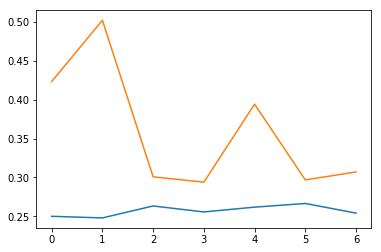

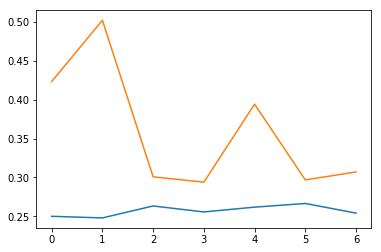

In [17]:
    
plt.plot(lastepoch_train_acc,label='train')
plt.plot(lastepoch_test_acc,label='test')
plt.show()
plt.plot(lastepoch_train_loss,label='train')
plt.plot(lastepoch_test_loss,label='test')
plt.show()